In [ ]:
# Import libraries
!pip install ngboost

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b192089ffadc2edd0579dfd348113232f11c1ac0f263df0a47d28406e5edc8c9
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Torsion_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,1.413961e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,3.969058e+04
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.258966e+04
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05


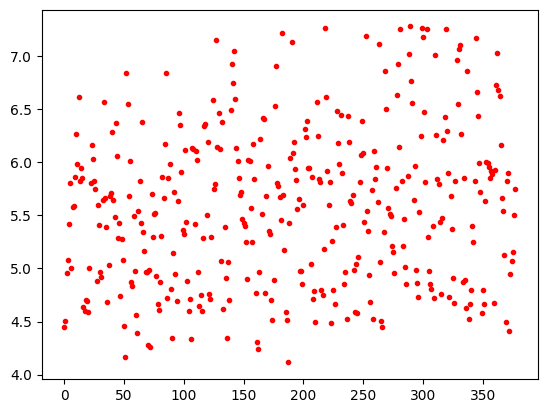

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,1.615986e+04
1,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01,8.962672e+03
2,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.778024e+04
3,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,7.521639e+03
4,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,3.701477e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.787854e+06
374,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,6.547304e+06
375,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,8.935626e+06
376,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,4.144169e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=1.0856 val_loss=1.1325 scale=1.0000 norm=0.4671
[iter 100] loss=0.7545 val_loss=0.7907 scale=1.0000 norm=0.3475
[iter 200] loss=0.4968 val_loss=0.5481 scale=2.0000 norm=0.7189
[iter 300] loss=0.2510 val_loss=0.3645 scale=2.0000 norm=0.7128
[iter 400] loss=0.0865 val_loss=0.3072 scale=2.0000 norm=0.6974
== Early stopping achieved.
== Best iteration / VAL400 (val_loss=0.3072)
Pearson CC: 0.8639495743027393
R2 score: 0.739743189784557
RMSE: 0.39220562495198774
MAE: 0.3059120868864734
Coverage: 89.4736842105263
Upper coverage: 93.42105263157893
Lower coverage: 96.05263157894736
Average Interval Width: 1.3849469177401528
Median Interval Width: 1.383826325120236
Composite Metric: 0.8517111401372942


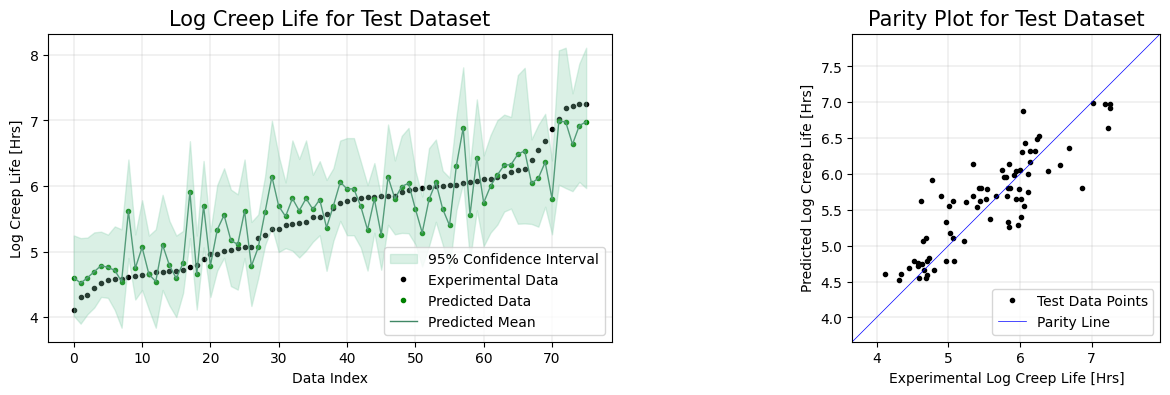

Run # 1 Fold # 2
[iter 0] loss=1.0800 val_loss=1.1131 scale=1.0000 norm=0.4756
[iter 100] loss=0.7443 val_loss=0.8149 scale=1.0000 norm=0.3523
[iter 200] loss=0.4180 val_loss=0.5827 scale=2.0000 norm=0.7599
== Early stopping achieved.
== Best iteration / VAL293 (val_loss=0.5216)
Pearson CC: 0.8908106826065694
R2 score: 0.7900762671705409
RMSE: 0.3626195500716778
MAE: 0.2868575740710531
Coverage: 98.68421052631578
Upper coverage: 99.99999999999999
Lower coverage: 98.68421052631578
Average Interval Width: 1.5891398753264776
Median Interval Width: 1.4200832350663446
Composite Metric: 0.9161775978191568


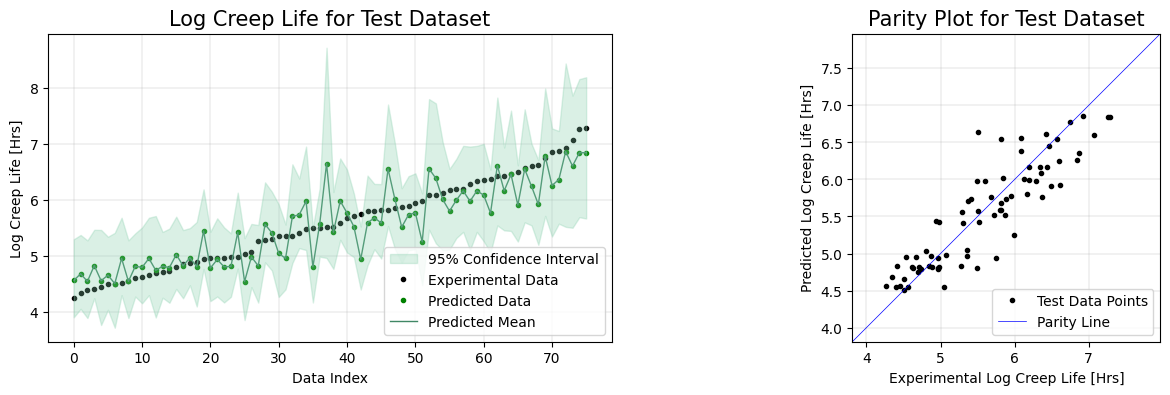

Run # 1 Fold # 3
[iter 0] loss=1.1145 val_loss=1.1511 scale=1.0000 norm=0.4669
[iter 100] loss=0.7780 val_loss=0.8273 scale=1.0000 norm=0.3477
[iter 200] loss=0.4730 val_loss=0.5559 scale=2.0000 norm=0.7490
[iter 300] loss=0.2361 val_loss=0.4220 scale=2.0000 norm=0.7466
== Early stopping achieved.
== Best iteration / VAL325 (val_loss=0.4144)
Pearson CC: 0.8691775830926026
R2 score: 0.7487188238245477
RMSE: 0.3480355514735742
MAE: 0.2884903449172757
Coverage: 98.68421052631578
Upper coverage: 99.99999999999999
Lower coverage: 98.68421052631578
Average Interval Width: 1.4346198626047764
Median Interval Width: 1.4069533213740888
Composite Metric: 0.9178204874577371


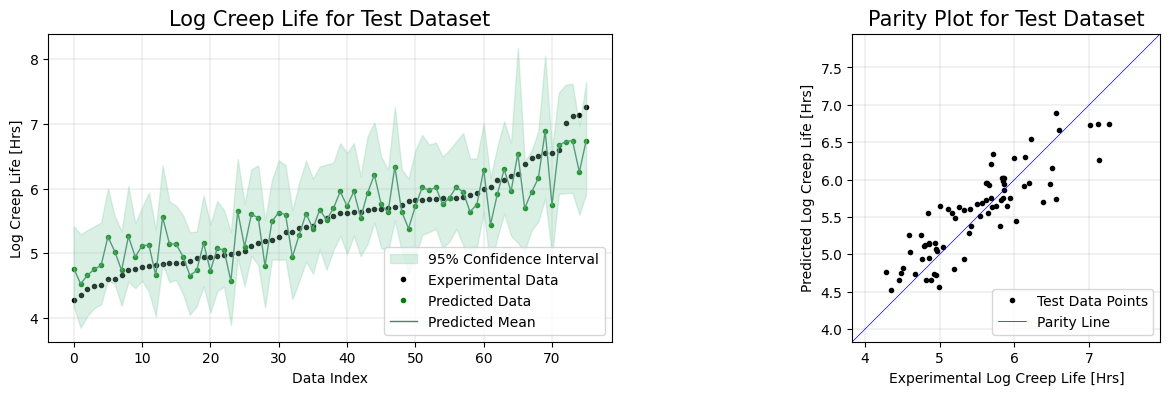

Run # 1 Fold # 4
[iter 0] loss=1.1048 val_loss=1.1377 scale=1.0000 norm=0.4611
[iter 100] loss=0.7275 val_loss=0.8079 scale=2.0000 norm=0.6868
[iter 200] loss=0.3924 val_loss=0.5807 scale=2.0000 norm=0.7535
== Early stopping achieved.
== Best iteration / VAL264 (val_loss=0.5377)
Pearson CC: 0.846283684359072
R2 score: 0.7026523987397192
RMSE: 0.39768699310716377
MAE: 0.3082247172257341
Coverage: 97.33333333333331
Upper coverage: 99.99999999999999
Lower coverage: 97.33333333333331
Average Interval Width: 1.5537793605645192
Median Interval Width: 1.4355204657398382
Composite Metric: 0.9041528636940435


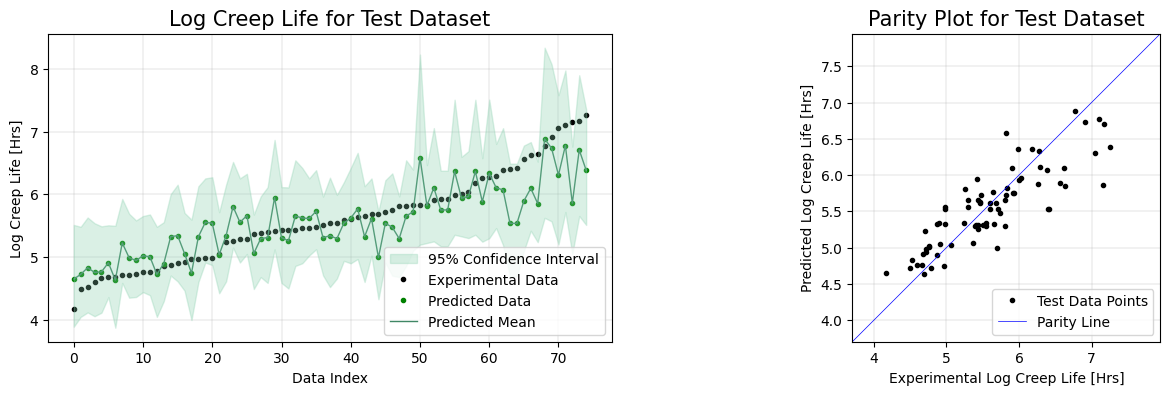

Run # 1 Fold # 5
[iter 0] loss=1.1041 val_loss=1.1441 scale=1.0000 norm=0.4681
[iter 100] loss=0.7126 val_loss=0.7665 scale=2.0000 norm=0.7047
[iter 200] loss=0.3712 val_loss=0.5021 scale=2.0000 norm=0.7389
[iter 300] loss=0.1435 val_loss=0.4021 scale=2.0000 norm=0.7156
== Early stopping achieved.
== Best iteration / VAL315 (val_loss=0.3981)
Pearson CC: 0.8399287774690256
R2 score: 0.70546887735733
RMSE: 0.3813546716175028
MAE: 0.30419798899278194
Coverage: 91.99999999999999
Upper coverage: 97.33333333333331
Lower coverage: 94.66666666666666
Average Interval Width: 1.3949714313875219
Median Interval Width: 1.376615024187724
Composite Metric: 0.8716048754425828


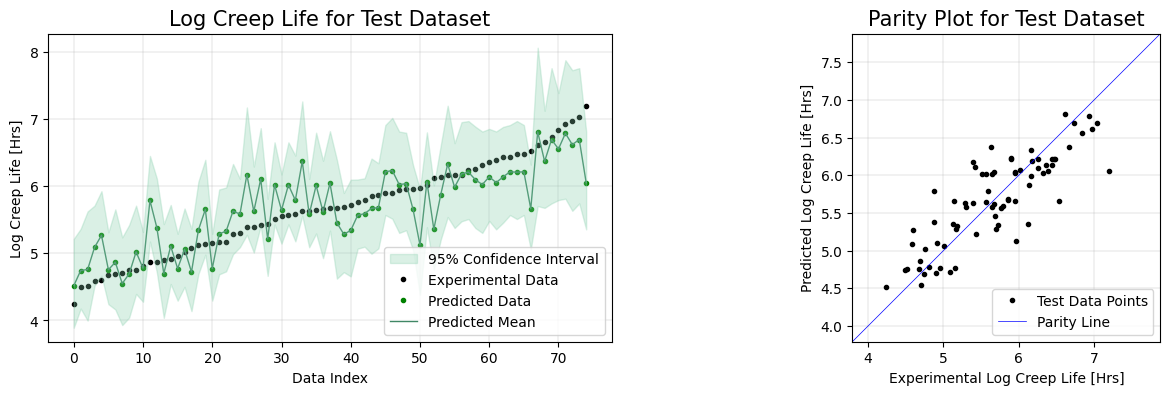

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)

            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)
            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')


            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.863950,0.739743,0.392206,0.305912,89.473684
1,0.890811,0.790076,0.362620,0.286858,98.684211
2,0.869178,0.748719,0.348036,0.288490,98.684211
3,0.846284,0.702652,0.397687,0.308225,97.333333
4,0.839929,0.705469,0.381355,0.304198,92.000000


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.86203,0.017997,0.737332,0.032048,0.37638,0.018558,0.298737,0.009137,95.235088,3.790913


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,89.473684,93.421053,96.052632,1.384947,1.383826,0.851711
1,98.684211,100.000000,98.684211,1.589140,1.420083,0.916178
2,98.684211,100.000000,98.684211,1.434620,1.406953,0.917820
3,97.333333,100.000000,97.333333,1.553779,1.435520,0.904153
4,92.000000,97.333333,94.666667,1.394971,1.376615,0.871605


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,95.235088,3.790913,98.150877,2.580596,97.084211,1.555039,1.471491,0.084044,1.4046,0.021982,0.892293,0.026221
